In [1]:
!export CUDA_VISIBLE_DEVICES=5

In [2]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../')

from jsonargparse import Namespace

import torch
from copy import deepcopy

from transformers import AutoTokenizer, GPTNeoForCausalLM

cfg = Namespace()
#cfg.tokenizer = '../../mix2_tokenizer.ckpt'
cfg.tokenizer = '../../updated_tokenizer.ckpt'
cfg.backbone_cpt = '../../mix2_2zywvs69.ckpt'
#cfg.pretrained_ckpt = '../logs/rmt_proofs_only/8zqqeuyw/checkpoints/last-v2.ckpt'
#cfg.pretrained_ckpt = '../logs/rmt_proofs_only/uujjbthq/checkpoints/last-v4.ckpt' # 1seg only global
#cfg.pretrained_ckpt = '../logs/rmt_proofs_only/8zqqeuyw/checkpoints/last-v4.ckpt' # 1seg with local
cfg.pretrained_ckpt = '../logs/rmt_proofs_only/0j3egx2o/checkpoints/last-v5.ckpt' # 1seg with local
cfg.num_mem_tokens = 10
cfg.max_n_segments = 2
cfg.input_size = 512
cfg.sum_loss = False
cfg.def_lemmas_loss_weight = 1.0
cfg.proof_loss_weight = 1.0
cfg.memory_forward_func = None
cfg.memory_layers = None
cfg.share_memory_layers = False
cfg.reconstruction_loss_coef = None
cfg.proof_loss_only = False
cfg.use_recur_mem = True
cfg.only_global = True

In [3]:
from transformers import AutoTokenizer, GPTNeoForCausalLM, GPTNeoConfig

tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer)

In [4]:
from modeling_rmt.lightning import RMTModelPL
from modeling_rmt.language_modeling import RMTDecoderForCausalLM

rmt_config = {
    "num_mem_tokens": cfg.num_mem_tokens,
    "max_n_segments": cfg.max_n_segments,
    "input_size": cfg.input_size,
    # "bptt_depth": cfg.bptt_depth,
    "sum_loss": cfg.sum_loss,
    "def_lemmas_loss_weight": cfg.def_lemmas_loss_weight,
    "proof_loss_weight": cfg.proof_loss_weight,
    "tokenizer": tokenizer,
    "memory_forward_func": cfg.memory_forward_func,
    "memory_layers": cfg.memory_layers,
    "share_memory_layers": cfg.share_memory_layers,
    "reconstruction_loss_coef": cfg.reconstruction_loss_coef,
    "proof_loss_only": cfg.proof_loss_only
    if hasattr(cfg, "proof_loss_only")
    else False,
    "proofstep_token_id": tokenizer.vocab["[PROOFSTEP]"],
    "use_recur_mem": cfg.use_recur_mem,
}

if cfg.only_global:
    local_backbone = GPTNeoForCausalLM.from_pretrained(cfg.backbone_cpt)

    config = local_backbone.config
    config.attention_types = [[["global"], 24]]
    config.attention_layers = ["global"] * 24

    backbone = GPTNeoForCausalLM(config)

    backbone.load_state_dict(local_backbone.state_dict())
else:
    backbone = GPTNeoForCausalLM.from_pretrained(cfg.backbone_cpt)

rmt_model = RMTDecoderForCausalLM(backbone, **rmt_config)

pl_model = RMTModelPL.load_from_checkpoint(
    cfg.pretrained_ckpt, rmt_model=rmt_model, strict=False
)

In [5]:
backbone.transformer.h[3].attn.attention_type

'global'

In [7]:
from lean_dataset import RMTProofsDataset

dataset = RMTProofsDataset(
    data_dir='../../lean_data/full_proofs_with_args/train',
    lemmas_path='../../lean_data/all_lemmas_statements.json',
    tokenizer=tokenizer,
    max_n_segments=7,
    segment_length=492
)
dataset.filter_shorts()
dataset.tokenize()

Found cached dataset parquet (/home/nesterov-va/.cache/huggingface/datasets/parquet/default-db9acf88104f4ce2/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


Filter:   0%|          | 0/15591 [00:00<?, ? examples/s]

In [8]:
sequences = [dataset[i] for i in range(1000, 2000, 100)]

memories = []
attentions = []
with torch.inference_mode(), torch.amp.autocast(dtype=torch.bfloat16, device_type='cuda'):
    for sequence in sequences:
        memories.append([])
        attentions.append([])
        for i, segment in enumerate(sequence):
            for key in segment:
                segment[key] = segment[key].to('cuda:0')
            segment['batch_idx'] = i
            del segment['labels']
            for key in ['input_ids', 'attention_mask']:
                segment[key] = segment[key].unsqueeze(0)
            out = pl_model(segment, output_attentions=True)

            # save write memory tokens
            memory = pl_model._module.memory_states[-1][1]
            memories[-1].append(memory)

            # save attention maps
            attentions[-1].append(out.attentions)
        

#     # cut at proof
#     idx = torch.where(sequence[-1]['input_ids'] == tokenizer.vocab['[PROOFSTEP]'])[0] + 1
    
#     input_ids = sequence[-1]['input_ids'][:idx]
#     attn_mask = sequence[-1]['attention_mask'][:idx]


#     # prepare input_embeds for the last segment
#     memory = pl_model._module.memory_states[-1][1].detach()
#     segment_input_ids = pl_model._module.pad_and_segment(input_ids.unsqueeze(0))[0]

#     seg_kwargs, non_empty_mask = pl_model._module.prepare_kwargs(
#         segment_input_ids,
#         {}
#         # {'attention_mask': attn_mask.unsqueeze(0)}
#     )
#     seg_kwargs["inputs_embeds"][:, pl_model._module.read_memory_position] = memory
    
#     generation = pl_model._module.model.generate(**seg_kwargs)
#     print(tokenizer.decode(generation[0]))

In [15]:
data = {'attentions': attentions, 'memories': memories, 'sequences': sequences}
torch.save(data, 'visualisation.pt')

In [4]:
import torch
import numpy as np

data = torch.load('visualisation.pt')
attentions, memories, sequences = data['attentions'], data['memories'], data['sequences']

Memories after first segment and after second segment differ:

In [ ]:
torch.norm(memories[0][6])

In [16]:
torch.norm(memories[0][6] - memories[0][5])

tensor(186.5622, device='cuda:0')

In [19]:
torch.norm(memories[0][5]), torch.norm(memories[0][6])

(tensor(253.4393, device='cuda:0'), tensor(268.6920, device='cuda:0'))

In [7]:
(sequences[1][2]["input_ids"][0] == PROOFSTEP_TOKEN).nonzero().item()

NameError: name 'PROOFSTEP_TOKEN' is not defined

In [16]:
tokenizer.decode(sequences[0][1]["input_ids"][0])

"lemma inv_mul_le_iff (h : 0 < b) : b⁻¹ * a ≤ c ↔ a ≤ b * c<lemma> theorem sublist.cons_cons {l₁ l₂ : list α} (a : α) (s : l₁ <+ l₂) : a::l₁ <+ a::l₂<lemma> lemma le_max_of_le_left : a ≤ b → a ≤ max b c<lemma> lemma to_real_le_to_real {x y : ereal} (h : x ≤ y) (hx : x ≠ ⊥) (hy : y ≠ ⊤) : x.to_real ≤ y.to_real<lemma> lemma mul_comm : ∀ a b : G, a * b = b * a<lemma> theorem uniformity_basis_edist' (ε' : ℝ≥0∞) (hε' : 0 < ε') : (𝓤 α).has_basis (λ ε : ℝ≥0∞, ε ∈ Ioo 0 ε') (λ ε, {p:α×α | edist p.1 p.2 < ε})<lemma> lemma div_le_iff' (hb : 0 < b) : a / b ≤ c ↔ a ≤ b * c<lemma> lemma inv_eq_one_div (x : G) : x⁻¹ = 1 / x<lemma> lemma closed_ball_disjoint_closed_ball {x y : α} {rx ry : ℝ} (h : rx + ry < dist x y) : disjoint (closed_ball x rx) (closed_ball y ry)<lemma> lemma π_arrow (j : J) : π arrows j ≫ arrows _ = base arrows<lemma> theorem erase_dup_singleton {a : α} : erase_dup ({a} : multiset α) = {a}[PAD][PAD][PAD][PAD][PAD][PAD][PAD]"

In [ ]:
tokenizer.encode("ℝ")

In [ ]:
tokenizer.encode("[PROOFSTEP]")

In [ ]:
sequences[0][1]["input_ids"][0]

In [11]:
tokenizer.encode("[AUX_LEMMA]")

[50262]

In [7]:
def find_lemma_tags(ids):
    '''
    Find all <lemma> positions in ids
    '''
    ans = []
    for i in range(len(ids)):
        if ids[i:i+4] == [27, 10671, 2611, 29]:
            ans.append(i)
    return ans

def new_find_lemma_tags(ids):
    '''
    Find all [AUX_LEMMA] positions in ids
    '''
    ans = []
    for i in range(len(ids)):
        if ids[i] == 50262:
            ans.append(i)
    return ans

In [60]:
find_lemma_tags(list(sequences[0][1]["input_ids"][0]))

[34, 90, 115, 177, 201, 297, 330, 358, 423, 450]

### How much weight have read memory vs prev tokens in proof generation

Насколько сильно модель при генерации пруфа смотрит на память? Построим график: по оси X отложим номер токена, по оси Y -- сумму весов отдаанных памяти (1 -- значит смотрит только на память, 0 -- только на предыдущие токены).

In [ ]:
# attentions[example][segment][layer][0][head] -- 512x512 attention matrix: (x,y) - how much attention token x pays to token y

In [8]:
N = 512
PROOFSTEP_TOKEN = 50274

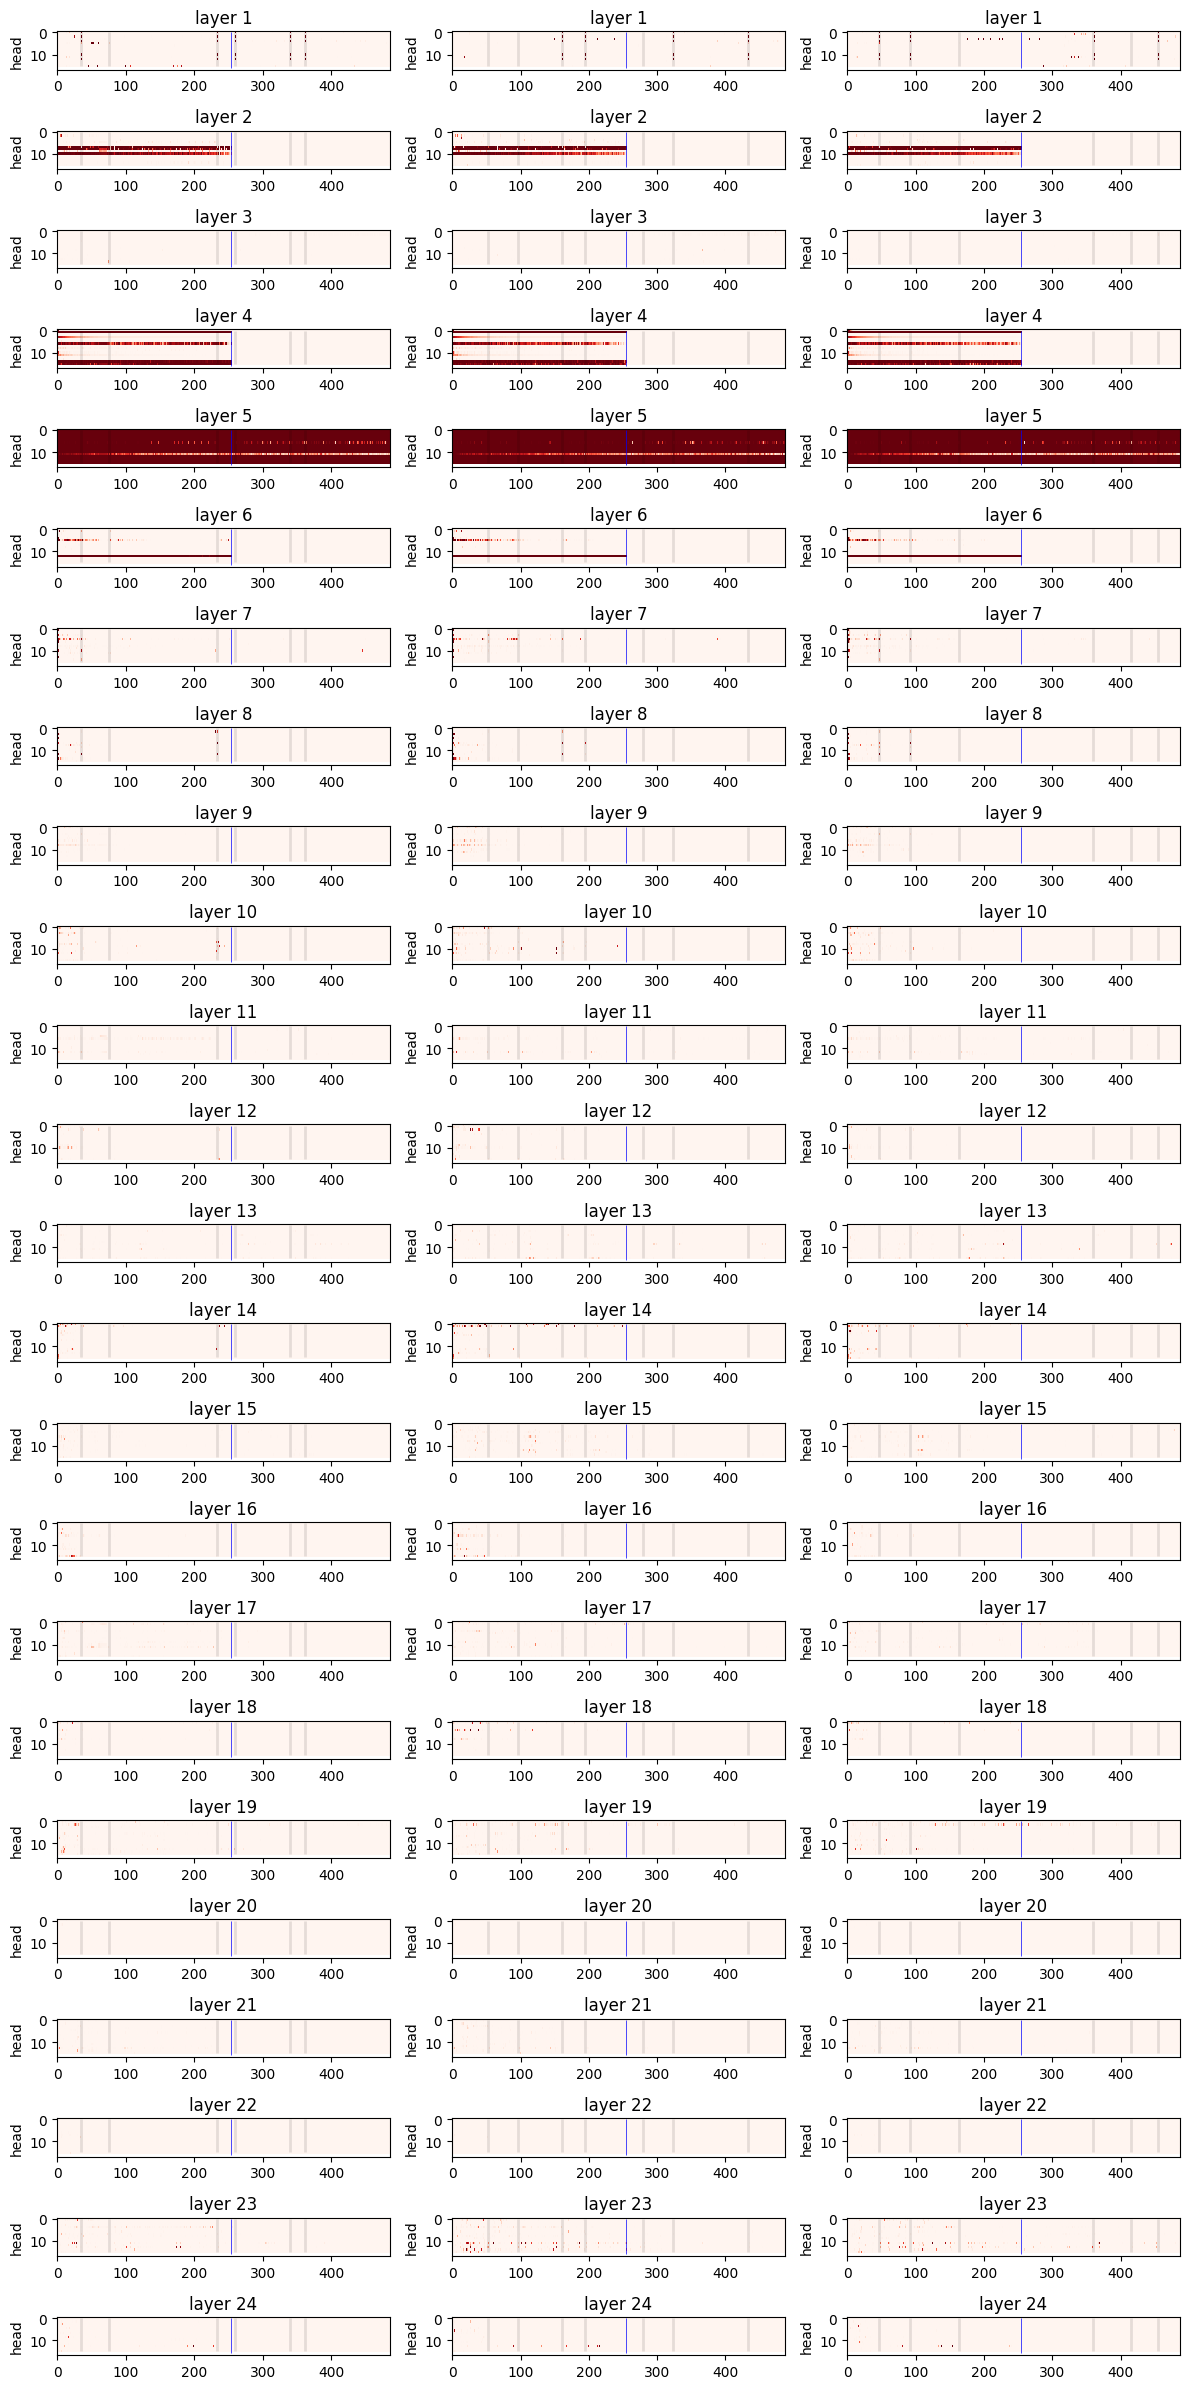

In [11]:
from matplotlib import pyplot as plt

layers = 24
segment = 4
examples = 3

fig, axs = plt.subplots(layers, examples, figsize=(12, 1 * layers))
for layer in range(layers):
    for example in range(examples):
        axs[layer, example].set_title(f"layer {layer + 1}")
        N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
        im = axs[layer, example].imshow(attentions[example][segment][layer][0, :, 10:N - 10, :10].sum(dim=-1).cpu().float(), 
                          vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
        #print(sequences[example][segment]["input_ids"])
        if segment == len(sequences[example]) - 1:
            proofstep_idx = (sequences[example][segment]["input_ids"] == PROOFSTEP_TOKEN).nonzero()[0][1].item()
            axs[layer, example].vlines(x = proofstep_idx + 10, ymin=0, ymax=16, color = 'g', linewidths=(0.5,))
        if N >= 254:
            axs[layer, example].vlines(x = 254, ymin=0, ymax=16, color = 'b', linewidths=(0.5,))
        lemmas_idxes = new_find_lemma_tags(list(sequences[example][segment]["input_ids"][0]))
        lemmas_idxes = [x for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens

        for lemma_idx in lemmas_idxes:
            axs[layer, example].vlines(x = lemma_idx, ymin=0, ymax=15, color = 'black', linewidths=(2,), alpha=0.1)
        axs[layer, example].set_ylabel('head')

plt.tight_layout()
plt.show()

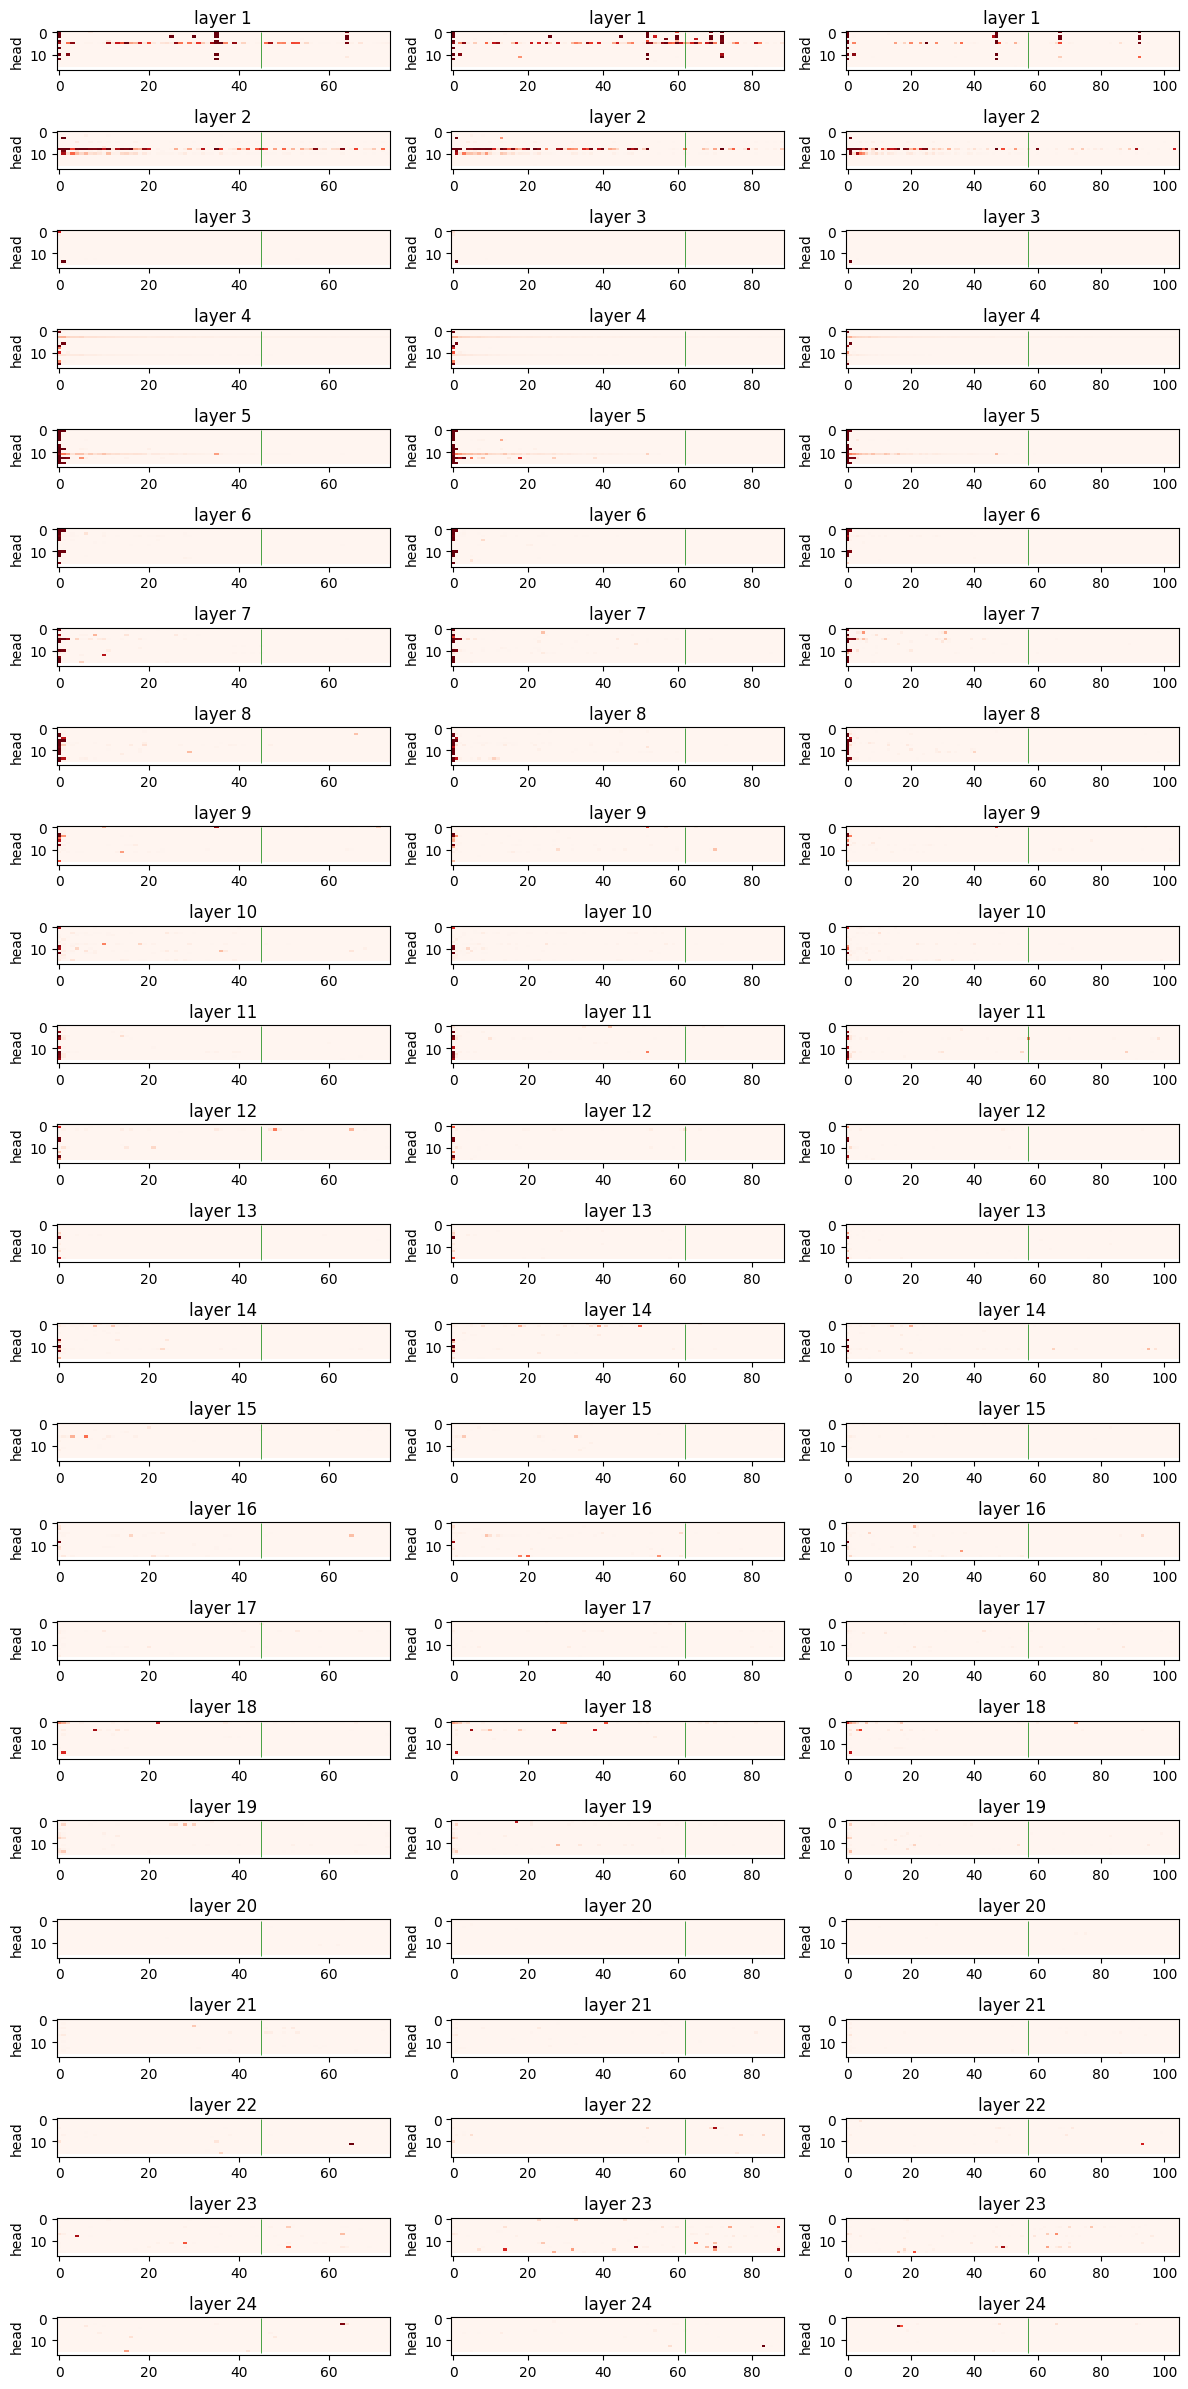

In [15]:
from matplotlib import pyplot as plt

layers = 24
segment = 6
examples = 3

fig, axs = plt.subplots(layers, examples, figsize=(12, 1 * layers))
for layer in range(layers):
    for example in range(examples):
        axs[layer, example].set_title(f"layer {layer + 1}")
        N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
        im = axs[layer, example].imshow(attentions[example][segment][layer][0, :, 10:N - 10, :10].sum(dim=-1).cpu().float(), 
                          vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
        #print(sequences[example][segment]["input_ids"])
        if segment == len(sequences[example]) - 1:
            proofstep_idx = (sequences[example][segment]["input_ids"] == PROOFSTEP_TOKEN).nonzero()[0][1].item()
            axs[layer, example].vlines(x = proofstep_idx + 10, ymin=0, ymax=16, color = 'g', linewidths=(0.5,))
        if N >= 254:
            axs[layer, example].vlines(x = 254, ymin=0, ymax=16, color = 'b', linewidths=(0.5,))
        lemmas_idxes = new_find_lemma_tags(list(sequences[example][segment]["input_ids"][0]))
        lemmas_idxes = [x for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens

        for lemma_idx in lemmas_idxes:
            axs[layer, example].vlines(x = lemma_idx, ymin=0, ymax=15, color = 'black', linewidths=(2,), alpha=0.1)
        axs[layer, example].set_ylabel('head')

plt.tight_layout()
plt.show()

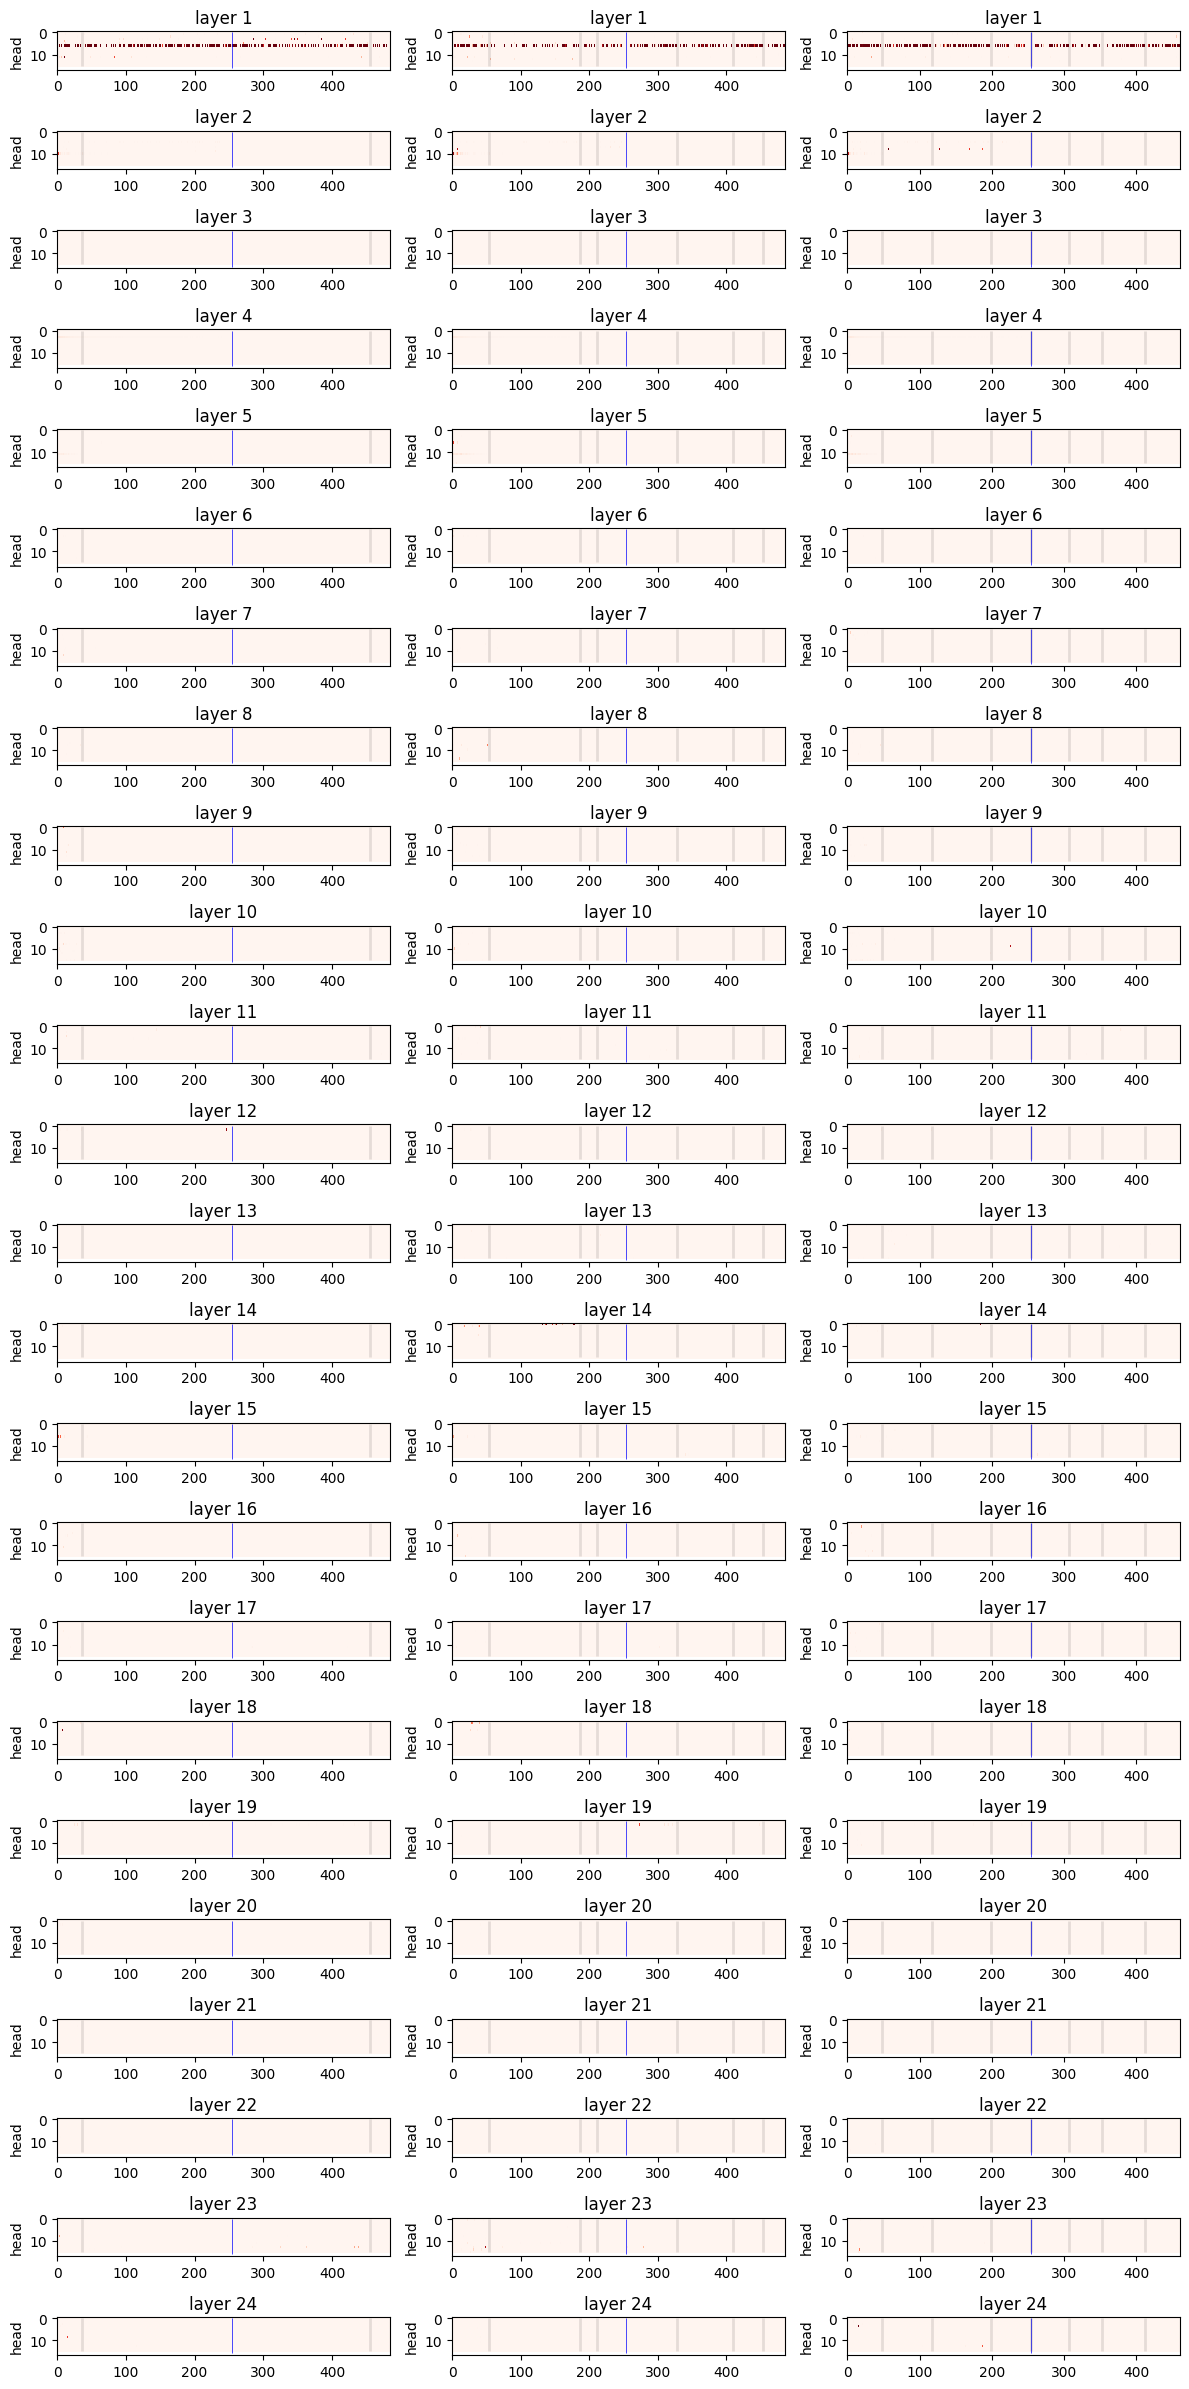

In [58]:
from matplotlib import pyplot as plt

layers = 24
segment = 3
examples = 3

fig, axs = plt.subplots(layers, examples, figsize=(12, 1 * layers))
for layer in range(layers):
    for example in range(examples):
        axs[layer, example].set_title(f"layer {layer + 1}")
        N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
        im = axs[layer, example].imshow(attentions[example][segment][layer][0, :, 10:N - 10, :10].sum(dim=-1).cpu().float(), 
                          vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
        #print(sequences[example][segment]["input_ids"])
        if segment == len(sequences[example]) - 1:
            proofstep_idx = (sequences[example][segment]["input_ids"] == PROOFSTEP_TOKEN).nonzero()[0][1].item()
            axs[layer, example].vlines(x = proofstep_idx + 10, ymin=0, ymax=16, color = 'g', linewidths=(0.5,))
        if N >= 254:
            axs[layer, example].vlines(x = 254, ymin=0, ymax=16, color = 'b', linewidths=(0.5,))
        lemmas_idxes = find_lemma_tags(list(sequences[example][segment]["input_ids"][0]))
        lemmas_idxes = [x + 2 for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens

        for lemma_idx in lemmas_idxes:
            axs[layer, example].vlines(x = lemma_idx, ymin=0, ymax=15, color = 'black', linewidths=(2,), alpha=0.1)
        axs[layer, example].set_ylabel('head')

plt.tight_layout()
plt.show()

Рассмотрим 5 слой отдельно:

IndexError: index 0 is out of bounds for dimension 0 with size 0

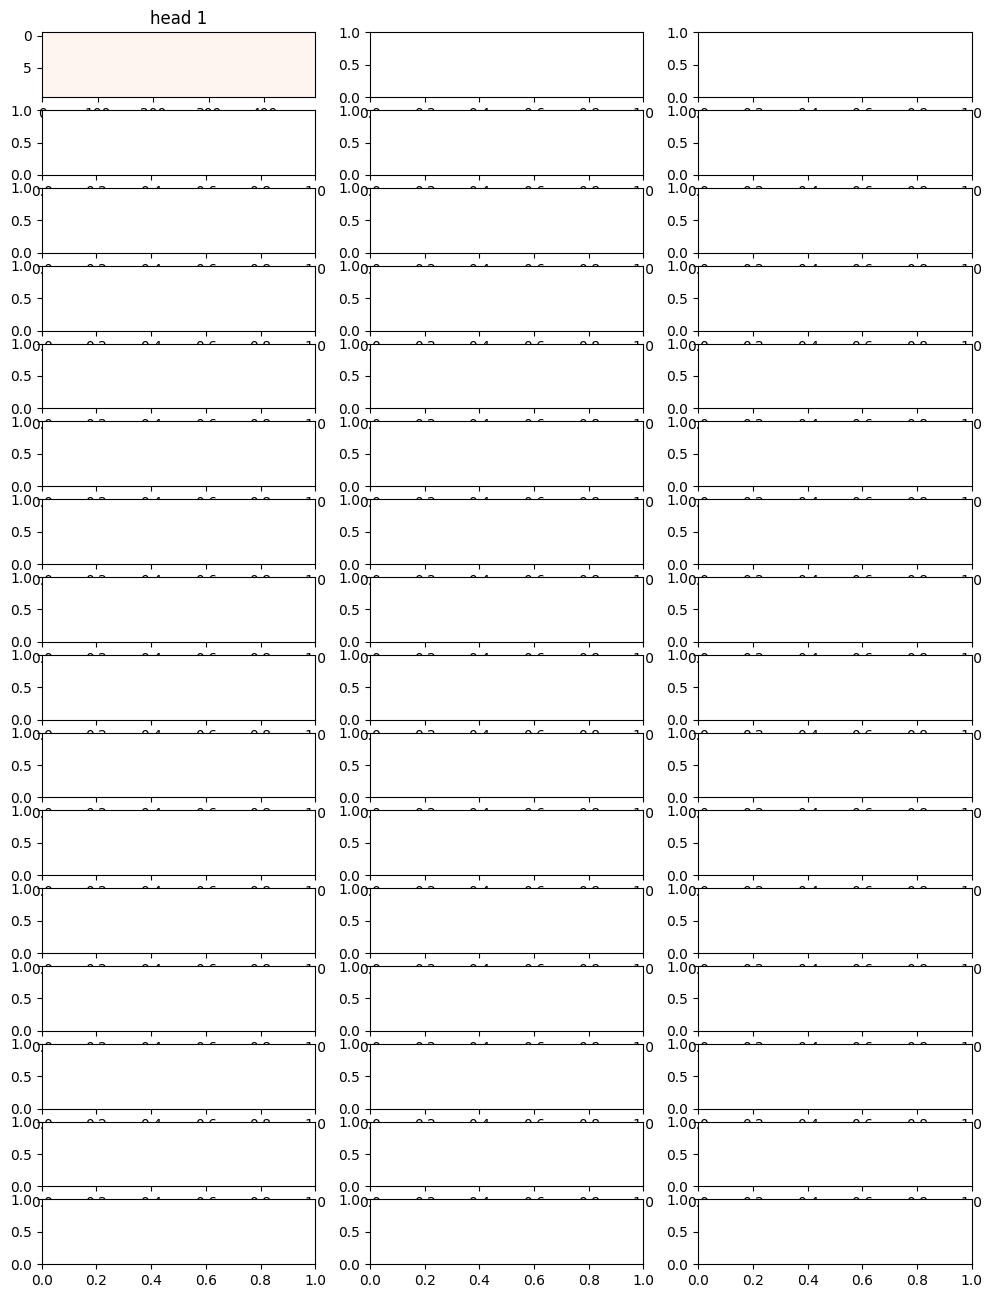

In [19]:
from matplotlib import pyplot as plt

layer = 4
segment = 2
examples = 3
heads = 16

fig, axs = plt.subplots(heads, examples, figsize=(12, 1 * heads))
for head in range(heads):
    for example in range(examples):
        idx = (head, example)
        axs[idx].set_title(f"head {head + 1}")
        #print(attentions[example][segment][layer][0, head, 10:502, :10].cpu().float().shape)
        im = axs[idx].imshow(attentions[example][segment][layer][0, head, 10:502, :10].T.cpu().float(), 
                          vmin=0, vmax=0.25, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
        
        proofstep_idx = (sequences[example][segment]["input_ids"] == PROOFSTEP_TOKEN).nonzero()[0][1].item()
        axs[idx].vlines(x = 254, ymin=0, ymax=10, color = 'b', linewidths=(0.5,))
        axs[idx].vlines(x = proofstep_idx + 10, ymin=0, ymax=10, color = 'g', linewidths=(0.5,))
        axs[idx].set_ylabel('head')

plt.tight_layout()
plt.show()

### Does it watch to [PROOFSTEP]?

Я строю полные карты внимания, помечая зеленой линией [PROOFSTEP].

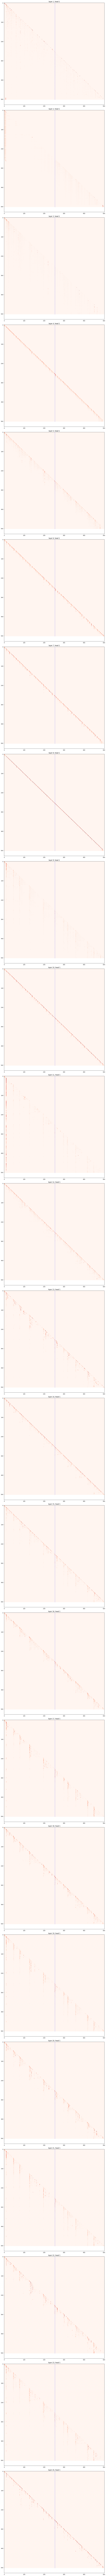

In [39]:
from matplotlib import pyplot as plt

layers = 24
segment = 4
heads = 1
example = 0

fig, axs = plt.subplots(layers * heads, 1, figsize=(12, 12 * layers * heads))
for layer in range(layers):
    for head in range(heads):
        idx = layer * heads + head
        axs[idx].set_title(f"layer {layer + 1}, head {head + 1}")
        N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
        im = axs[idx].imshow(attentions[example][segment][layer][0, head, :N, :N].cpu().float(), 
                          vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
        #print(sequences[example][segment]["input_ids"])
        #proofstep_idx = (sequences[example][segment]["input_ids"] == PROOFSTEP_TOKEN).nonzero()[0][1].item()
        axs[idx].vlines(x = 254, ymin=0, ymax=N.item(), color = 'b', linewidths=(0.5,))
        #axs[idx].vlines(x = proofstep_idx + 10, ymin=0, ymax=512, color = 'g', linewidths=(2,), alpha=0.2)
        #axs[layer, example].set_ylabel('head')

plt.tight_layout()
plt.show()

### Does model look to lemmas names making write memory?

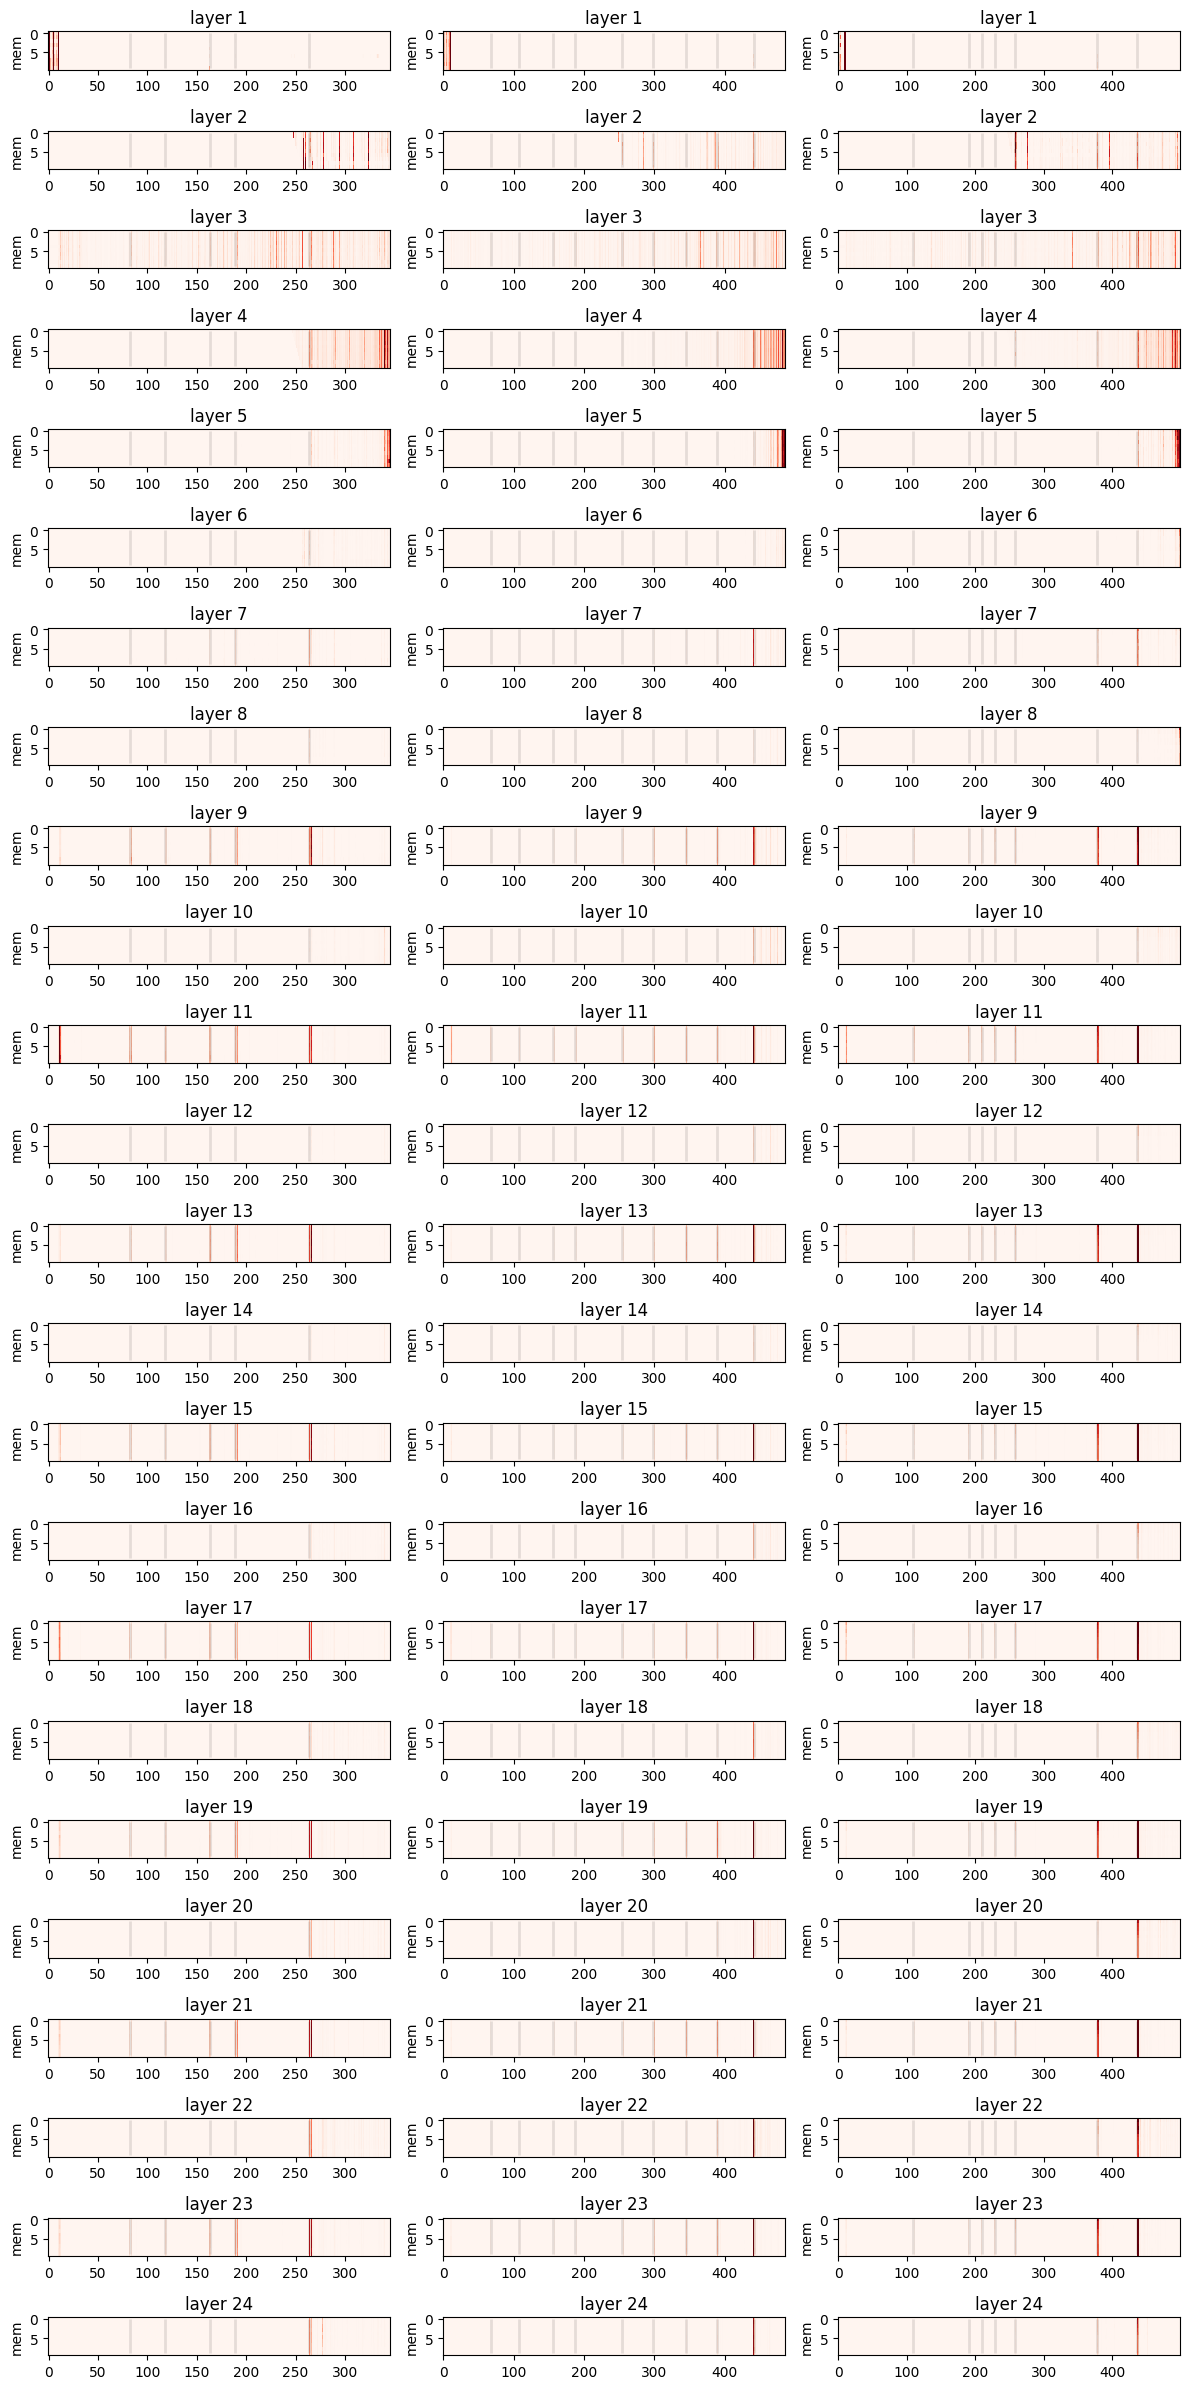

In [21]:
from matplotlib import pyplot as plt

layers = 24
segment = 1
examples = 3

fig, axs = plt.subplots(layers, examples, figsize=(12, 1 * layers))
for layer in range(layers):
    for example in range(examples):
        N = (sequences[example + 3][segment]['attention_mask'][0] == 1).sum() + 20
        
        axs[layer, example].set_title(f"layer {layer + 1}")
        im = axs[layer, example].imshow(attentions[example + 3][segment][layer][0, :, 502:, :N - 10].sum(dim=0).cpu().float(), 
                          vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
        #print(sequences[example][segment]["input_ids"])
        #proofstep_idx = (sequences[example][segment]["input_ids"] == PROOFSTEP_TOKEN).nonzero()[0][1].item()
        #axs[layer, example].vlines(x = 254, ymin=0, ymax=9, color = 'b', linewidths=(0.5,))
        #axs[layer, example].vlines(x = proofstep_idx + 10, ymin=0, ymax=16, color = 'g', linewidths=(0.5,))

        lemmas_idxes = new_find_lemma_tags(list(sequences[example + 3][segment]["input_ids"][0]))
        lemmas_idxes = [x + 10 for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens

        for lemma_idx in lemmas_idxes:
            axs[layer, example].vlines(x = lemma_idx, ymin=0, ymax=9, color = 'black', linewidths=(2,), alpha=0.1)
        
        axs[layer, example].set_ylabel('mem')

plt.tight_layout()
plt.show()

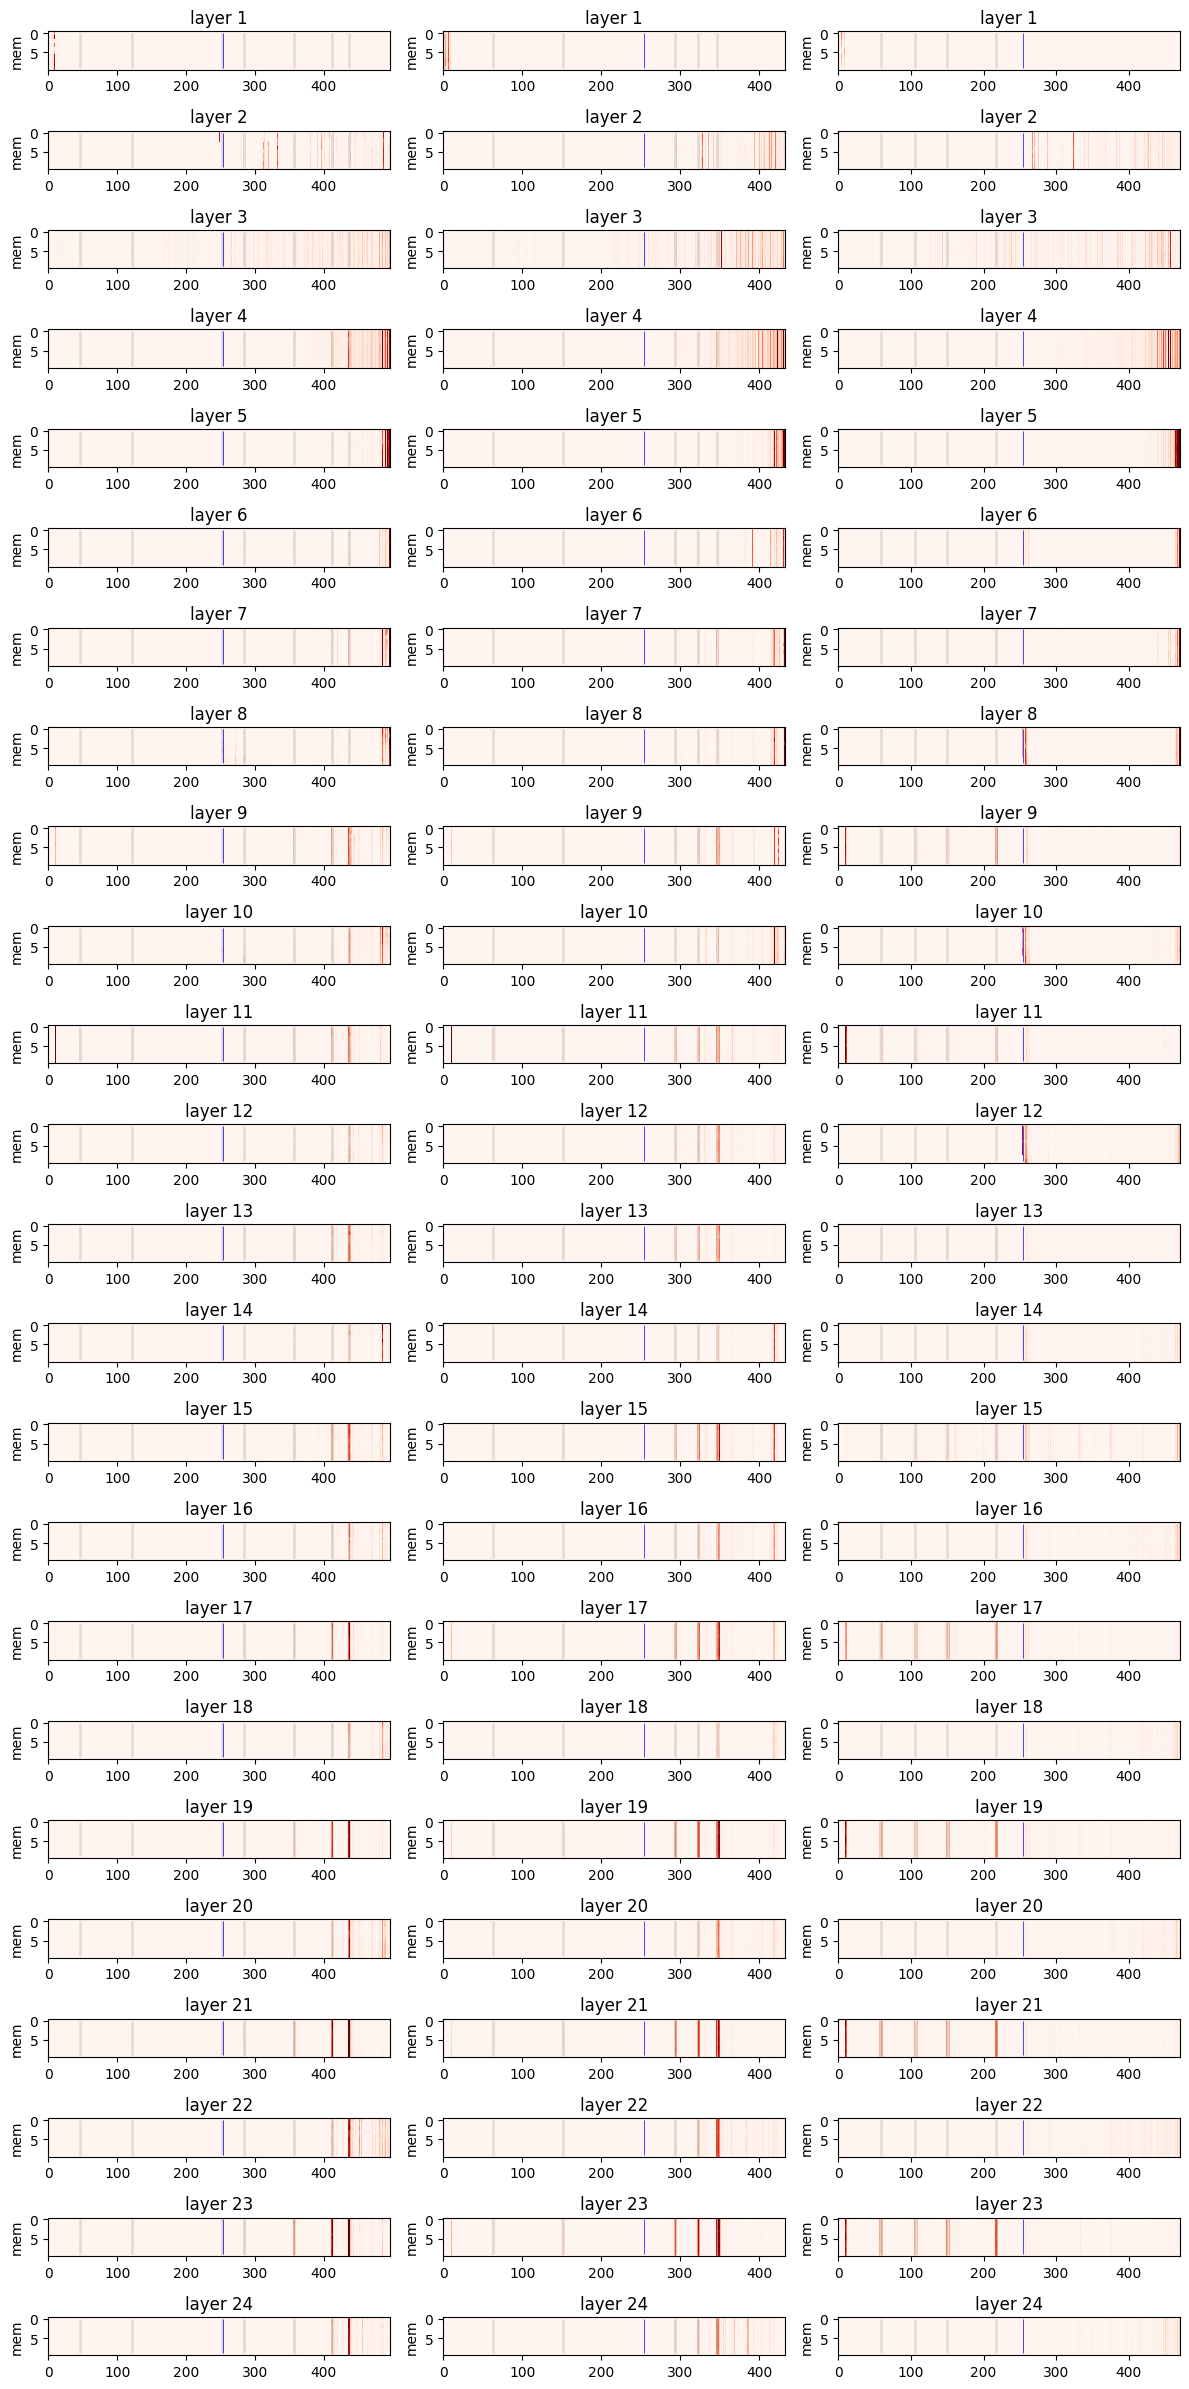

In [32]:
from matplotlib import pyplot as plt

layers = 24
segment = 5
examples = 3

fig, axs = plt.subplots(layers, examples, figsize=(12, 1 * layers))
for layer in range(layers):
    for example in range(examples):
        N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
        
        axs[layer, example].set_title(f"layer {layer + 1}")
        im = axs[layer, example].imshow(attentions[example][segment][layer][0, :, 502:, :N - 10].sum(dim=0).cpu().float(), 
                          vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
        #print(sequences[example][segment]["input_ids"])
        #proofstep_idx = (sequences[example][segment]["input_ids"] == PROOFSTEP_TOKEN).nonzero()[0][1].item()
        axs[layer, example].vlines(x = 254, ymin=0, ymax=9, color = 'b', linewidths=(0.5,))
        #axs[layer, example].vlines(x = proofstep_idx + 10, ymin=0, ymax=16, color = 'g', linewidths=(0.5,))

        lemmas_idxes = find_lemma_tags(list(sequences[example][segment]["input_ids"][0]))
        lemmas_idxes = [x + 12 for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens

        for lemma_idx in lemmas_idxes:
            axs[layer, example].vlines(x = lemma_idx, ymin=0, ymax=9, color = 'black', linewidths=(2,), alpha=0.1)
        
        axs[layer, example].set_ylabel('mem')

plt.tight_layout()
plt.show()